# 2D linear elasticity

### TODO
- difference between plain strain and plain stress (Jarda)
- comment the usage of `AutoSubDomain` function (Jarda)

### Problem definition
In this exercise we solve a two-dimensional boundary-value problem of elastostatics in the framework of linear theory of elasticity. The corresponding governing equation reads
\begin{equation}
    \mathrm{div}\boldsymbol{\sigma} + \mathbf{b} = \mathbf{0},
\end{equation}
where $\mathbf{b}$ denotes a volumetric force, and $\boldsymbol{\sigma}$ denotes the stress tensor which is, for an isotropic material, given by
\begin{equation}
    \boldsymbol{\sigma}=\lambda\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}, \end{equation}
and the strain tensor $\boldsymbol{\varepsilon}$ takes the form
\begin{equation}
    \boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\mathbf{u}+ \left( \nabla\mathbf{u} \right)^{\top} \right),
\end{equation}
where $\lambda, \mu$ are Lame's constants which are given through the relations
\begin{equation}
    \lambda = \frac{E \nu}{(1 + \nu) (1 - 2 \nu)},
    \qquad
    \mu = \frac{E}{2(1 + \nu)},
\end{equation}
where $E$ and $\nu$ denote the Young's modulus and the Poisson ratio.

The problem is supplemented with boundary conditions
\begin{align}
    \boldsymbol{\sigma}\cdot\mathbf{n}
    &=
    \mathbf{g}, &  &\forall \mathbf{x}\in\Gamma_N,
    \\
    \mathbf{u}(\mathbf{x})
    &=
    \bar{\mathbf{u}}, & &\forall \mathbf{x}\in\Gamma_D,
\end{align}
where $\mathbf{g}$ denotes a surface force, $\Gamma_N$ denotes the part of boundary where Neumann boundary condition is prescribed, and $\Gamma_D$ denotes the part of boundary where Dirichlet boundary condition is prescribed.

Testing the governing equation by $\delta\mathbf{u}$, integrating over the spatial domain $\Omega$, and integrating by parts yields the weak formulation of our problem. That is, find $\mathbf{u}$ such that
\begin{equation}
    \int_{\Omega} \boldsymbol{\sigma} : \delta \boldsymbol{\varepsilon} \, \mathrm{dV} 
    =
    \int_{\Omega} \mathbf{b}\cdot\delta\mathbf{u} \, \mathrm{dV} 
    + 
    \int_{\Gamma_N}\mathbf{g}\cdot\delta\mathbf{u} \, \mathrm{dS}, 
    \qquad 
    \forall \delta\mathbf{u},
\end{equation}
where $\delta\boldsymbol{\varepsilon}$ is the symmetric gradient of $\delta\mathbf{u}$ and
\begin{align}
\mathbf{u}(\mathbf{x}) = \bar{\mathbf{u}}, & &\forall \mathbf{x}\in\Gamma_D,
\\
\delta\mathbf{u}(\mathbf{x}) = \mathbf{0}, & &\forall \mathbf{x}\in\Gamma_D.
\end{align}


### Implementation


After importing the standard libraries we define several auxiliary functions

In [1]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
# Bottom boundary
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

The function `bottom` defines a set of points which are at the bottom boundary. Here, `x` represents a vector of spatial coordinates, i.e. `x[0]` is the $x$ coordinate, `x[1]` is the $y$ coordinate. Functions `epsilon` and `sigma` define strain and stress tensors as a function of displacement field $\mathbf{u}$ (or `u` in code). These functions are defined symbolically using several FEniCS objects or functions. Here is a short table of frequently used ones

| FEniCS object | Description |
| -- | -- |
| fe.grad(u) | Gradient of function u |
| fe.div(u) | Divergence of function u |
| fe.dot(u, v) | Dot product between u and v |
| fe.inner(u, v) | Inner product between u and v |
| fe.Identity(d) | Identity tensor with dimension d |
| fe.sym(A) | Symmetric part of A |
| fe.dev(A) | Deviatoric part of A |
| .T | Transposition of tensor |

For more examples see the [documentation](https://fenicsproject.org/docs/ufl/1.6.0/ufl.html#ufl-package).

The physical and computational parameters are set as follows

In [2]:
# --------------------
# Parameters
# --------------------
# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.1

# Lame's constants
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_int = 1.0
b_int = 1.0
F_con = -3.0e-1

A structured rectangular mesh can be created by FEniCS object `RectangleMesh`

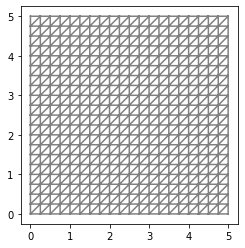

In [3]:
# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

fe.plot(mesh)
plt.show()

By default, the mesh is generated with the triangles oriented to the "right". The orientation can be changed by adding `"left"` as the last argument

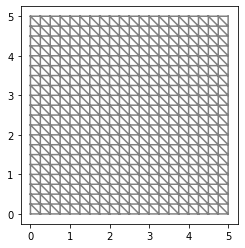

In [4]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left"))
plt.show()

Other types of mesh include `"crossed"` and `"left/right"` 

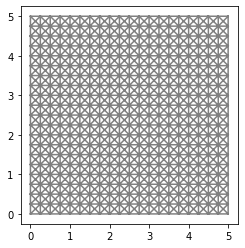

In [5]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "crossed"))
plt.show()

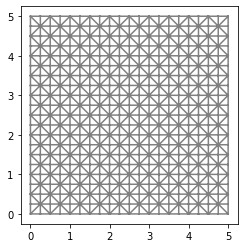

In [6]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left/right"))
plt.show()

Also, quadrilateral type of mesh is supported but it is not fully implemented. For example this mesh cannot be plotted directly by `fe.plot()`. A square quadrilateral mesh is generated by FEniCS object `UnitSquareMesh`

In [7]:
mesh_quad = fe.UnitSquareMesh.create(n_x, n_y, fe.CellType.Type.quadrilateral)

The best option for creating a mesh is loading it as an external `.xml` file using the `Mesh` object

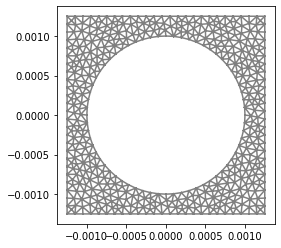

In [8]:
fe.plot(fe.Mesh("external_mesh.xml"))
plt.show()

The external `.xml` file can be generated for example using the [Gmsh](http://gmsh.info/) software. See a short [tutorial](http://mypages.iit.edu/~asriva13/?page_id=586) on generating a mesh with Gmsh and importing it into FEniCS, or the full [documentation](http://gmsh.info/doc/texinfo/gmsh.html) if needed.

Definition of domain part where Neumann boundary conditions are prescribed. (TODO)

In [9]:
# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

In this example trial and test functions are vector functions, therefore instead of operating on a scalar space $V$ we work with a vector function space ($V\times V$ in 2D and $V\times V\times V$ in 3D). This is done by calling `VectorFunctionSpace` from FEniCS package

In [10]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

We again use Lagrange elements with order 1. The following table summarizes several other options of approximation spaces (more exhaustive list can be found [here](https://fenicsproject.org/olddocs/dolfin/1.3.0/python/programmers-reference/functions/functionspace/FunctionSpace.html))

| Keyword | Description |
| -- | -- |
| "CG" | Lagrange / Continous Galerkin |
| "DG" | Discountinous Galerkin |
| "HER" | Hermit elements - only partly supported |
| "B" | Bubble functions |

Vector function defined in this space must be defined using a tuple as

In [11]:
g = fe.Constant((0.0, g_int))
b = fe.Constant((0.0, b_int))

Dirichlet boundary conditions are defined the same way

In [12]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

Alternatively, we can restrict displacements in one direction only. In this case, the first argument of `DirichletBC` is a subspace of the vector function space. For example the following piece of code prescribes zero displacement in the $y$-direction

In [13]:
bc = fe.DirichletBC(V.sub(1), 0.0, bottom)

The weak form is implemented using pre-defined FEniCS operators as follows

In [14]:
# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(g, u_test)*ds(1)

The objects `dx` and `ds` represent integration domain. Three basic integration domains are implemented

| FEniCS object | Description |
| -- | -- |
| fe.dx | Integration over domain volume |
| fe.ds | Integration over outer boundary |
| fe.dS | Integration over internal boundary |

Moreover, integration domain accepts the optional argument which defines only part of the domain. For example domain *fe.ds(1)* represents part of outer boundary which is labeled by integer 1. Such labeling has been introduced above.

To solve the problem, it is possible to use `fe.solve(a==l, V, bc)` again. However, we introduce another solution that is useful when we need to access the system matrices directly. For this purpose FEniCS provides function `assembly_system` with three arguments: left-hand side, right-hand side, and Dirichlet boundary conditions. This function returns assembled matrix `A` of the system and a vector `L` of the right-hand side. Assembling is based on the selected type of function space. The variational continuous system is converted into an algebraic system $\mathbf{A}\mathbf{x}=\mathbf{L}$. The regularity of $\mathbf{A}$ is affected e.g. by the mesh degeneracy, an improper set of boundary conditions, or by the insuffuciency of the numerical integration.

In [15]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
A, L = fe.assemble_system(a, l, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.


FEniCS provides an overloaded function `solve` for solving linear system, which returns vector of displacements. Therefore we must use `u.vector()` as the second argument. Function `u.vector()` returns vector of `u` function.

In [16]:
fe.solve(A, u.vector(), L)

1

### Post-process

Node values can be accessed by `.vector()` function. It returns iterable `PETScVector` object which enables us to manipulate with nodal values. Since the displacement is a vector field it cannot be plotted directly. We must specify scalar subspace for plotting

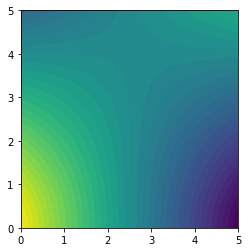

In [17]:
fe.plot(u.sub(0))
plt.show()

A second option for visualization of the result is to call an optional argument mode with value `"displacement"` which plots the displaced domain

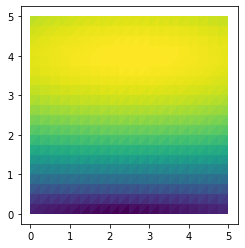

In [18]:
fe.plot(u, mode="displacement")
plt.show()

Stress can be plotted similarly but since it is a second-order tensor we must specify a scalar subspace by two indices. For example stress $\sigma_{yy}$ is obtained by `sigma(u)[1,1]`

Calling FFC just-in-time (JIT) compiler, this may take some time.


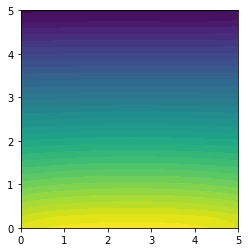

In [19]:
stress = sigma(u)
fe.plot(stress[1, 1])
plt.show()

This procedure is sufficient for plotting components of sigma or for reusing sigma in another weak form. However, if we need to access stress nodal values, we must first project it onto a suitable space. The displacement field lives in `CG1`, so the corresponding space for stress is `DG0` space. Moreover, since stress is a second-order tensor we must define `TensorFunctionSpace`

Calling FFC just-in-time (JIT) compiler, this may take some time.


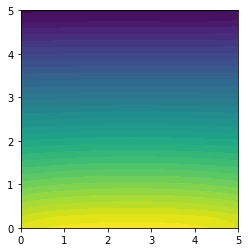

In [20]:
V0 = fe.TensorFunctionSpace(mesh, "DG", 0)
stress_1 = fe.project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

<div class="alert alert-block alert-success">
    Projection of function $u\in V$ onto a space $W$ means the following variational problem:
    \begin{equation}
    \text{Find}\,g\in W\,\text{s.t.}\,\int_\Omega uv\ \mathrm{d}\Omega = \int_\Omega gv\ \mathrm{d}\Omega,\ \forall v\in W.
    \end{equation}
</div>

It can be a useful tool to convert a function into a non-corresponding space. However, the stress is obtained from the displacement by differentiation of the basis functions and thus the projection can be unnecessarily expensive. More effective way is to make the projection element-wise. Since we want to project the stress on `DG0` space, where no continuity at nodes is required, we can perform this local projection without loss of generality. It can be done by the following subroutine

Calling FFC just-in-time (JIT) compiler, this may take some time.


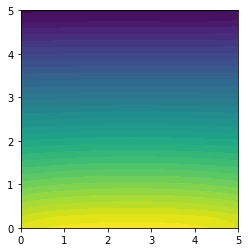

In [21]:
def local_project(fce, space):
    lp_trial, lp_test = fe.TrialFunction(space), fe.TestFunction(space)
    lp_a = fe.inner(lp_trial, lp_test)*fe.dx
    lp_L = fe.inner(fce, lp_test)*fe.dx
    local_solver = fe.LocalSolver(lp_a, lp_L)
    local_solver.factorize()
    lp_f = fe.Function(space)
    local_solver.solve_local_rhs(lp_f)
    return lp_f
stress_2 = local_project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

### Code

0.03294976523774759


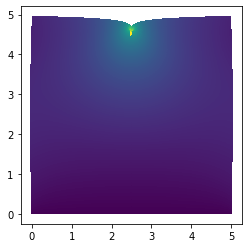

In [22]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 500, 500  # Number of elements

# Load
f_int = 0.0
b_int = 0.0
F_con = -3.0e-1

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
f = fe.Constant((0.0, f_int))
b = fe.Constant((0.0, b_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(f, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
A_ass, L_ass = fe.assemble_system(a, l, bc)

# Dirac function load intensity
pointForce = fe.PointSource(V.sub(1), fe.Point((0.5*l_x, l_y)), F_con)
pointForce.apply(L_ass)

fe.solve(A_ass, u.vector(), L_ass)

print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()